In [ ]:
%matplotlib inline
import numpy as np
import mss
import matplotlib.pyplot as plt
import tensorflow as tf

def ss():
    with mss.mss() as sct:
        # Part of the screen to capture
        monitor = {'top': 0, 'left': 0, 'width': 300, 'height': 300}

        # Get raw pixels from the screen, save it to a Numpy array
        return np.array(sct.grab(monitor))[:,:,:3]
    
img = ss()
plt.imshow(img)

tf.contrib.slim.conv3d(activation_fn=tf.)

In [ ]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.animation as animation
from matplotlib import pyplot as plt
from IPython.display import HTML

W = 30
H = 30

#state0 = tf.ones([H,W]) #tf.random_uniform([H,W], maxval=2, dtype=tf.int32)
#state0 = tf.random_uniform([H,W], maxval=2, dtype=tf.int32)
npstate0 = np.zeros([H,W])
npstate0[2,5] = 1
npstate0[3,5] = 1
npstate0[4,5] = 1
state0 = tf.convert_to_tensor(npstate0)
state = tf.Variable(tf.cast(tf.reshape(state0,[1,H,W,1]), tf.float32))
kernel = tf.reshape(tf.ones([3,3]), [3,3,1,1])
neighbours = tf.nn.conv2d(state, kernel, [1,1,1,1], "SAME") - state
survive = tf.logical_and( tf.equal(state, 1), tf.equal(neighbours, 2))
born = tf.equal(neighbours, 3)
newstate = tf.cast(tf.logical_or(survive, born), tf.float32)

init = tf.initialize_all_variables()



fig = plt.figure()
with tf.Session() as sess:
    sess.run(init)
    sess.run(newstate)
    newstate_ = sess.run(tf.reshape(newstate, [H,W]))
    sess.run(tf.assign(state, newstate))
    plot = plt.imshow(newstate_, cmap='Greys', interpolation='nearest')

    def animateFn(num, sess, state, newstate):
        sess.run(newstate)
        newstate_ = sess.run(tf.reshape(newstate, [H,W]))
        sess.run(tf.assign(state, newstate))
        plot.set_array(newstate_)
        return plot

    anim = animation.FuncAnimation(fig, animateFn, 5, fargs=(sess, state, newstate), interval=2, blit=False)
    HTML(anim.to_html5_video())

In [ ]:
%matplotlib inline
np.set_printoptions(threshold=np.nan)
def life_step(X):
    """Game of life step using scipy tools"""
    from scipy.signal import convolve2d
    nbrs_count = convolve2d(X, np.ones((4, 4)), mode='same', boundary='wrap') - X
    #return (nbrs_count == 1) | (X & (nbrs_count == 2))
    return X & (nbrs_count == 4)
    
# JSAnimation import available at https://github.com/jakevdp/JSAnimation
from JSAnimation.IPython_display import display_animation, anim_to_html
from matplotlib import animation

def life_animation(X, dpi=10, frames=10, interval=300, mode='loop'):
    """Produce a Game of Life Animation
    
    Parameters
    ----------
    X : array_like
        a two-dimensional numpy array showing the game board
    dpi : integer
        the number of dots per inch in the resulting animation.
        This controls the size of the game board on the screen
    frames : integer
        The number of frames to compute for the animation
    interval : float
        The time interval (in milliseconds) between frames
    mode : string
        The default mode of the animation.  Options are ['loop'|'once'|'reflect']
    """
    X = np.asarray(X)
    assert X.ndim == 2
    X = X.astype(bool)
    
    X_blank = np.zeros_like(X)
    figsize = (X.shape[1] * 10. / dpi, X.shape[0] * 10. / dpi)

    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1], xticks=[], yticks=[], frameon=False)
    im = ax.imshow(X, cmap=plt.cm.binary, interpolation='nearest')
    im.set_clim(-0.05, 1)  # Make background gray

    # initialization function: plot the background of each frame
    def init():
        im.set_data(X_blank)
        return (im,)

    # animation function.  This is called sequentially
    def animate(i):
        im.set_data(animate.X)
        animate.X = life_step(animate.X)
        return (im,)
    animate.X = X

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=frames, interval=interval)
    
    #print anim_to_html(anim)
    return display_animation(anim, default_mode=mode)

np.random.seed(0)
X = np.zeros((30, 40), dtype=bool)
r = np.random.random((10, 20))
X[10:20, 10:30] = (r > 0.75)
life_animation(X, dpi=10, frames=50, mode='once')

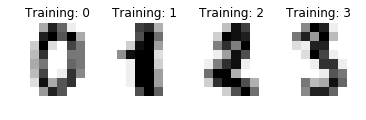

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics

# The digits dataset
digits = datasets.load_digits()

X = np.array([ [0,0,1],[0,1,1],[1,0,1],[1,1,1] ])
y = np.array([[0,1,1,0]]).T
syn0 = 2*np.random.random((3,4)) - 1

l1 = 1/(1+np.exp(-(np.dot(X,syn0))))

images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)


In [9]:
import numpy as np 

class FCM():
    def __init__(self, neurons):
        self.N = neurons #neurons
        self.TH = 50 #threshold
        self.D = 10 #time to be active
        self.C = 100 #interval for connection weakining
        self.S = 1 #connection strength increase
        self.W = 1 #connection strength decrease
        self.R = 1 #state decay rate

        self.state = np.zeros((self.N))
        self.previous_state = np.zeros((self.N))
        self.th = np.zeros((self.N))
        self.conn = np.zeros((self.N,self.N))
        self.i = 0

    def step(self, signal):
        self.th += signal

        self.state[self.th>=self.TH] = self.D

        self.th[self.th>=self.TH] = 0

        self.th += np.sum(self.conn[:,self.state>0], axis=1)

        if self.i > 0:
            mask = np.zeros((self.N,self.N), dtype=np.bool)
            mask[:,self.previous_state>0] = True
            mask[self.state==self.D,:] = True
            mask[self.previous_state>0,:] = False
            self.conn[mask] += self.S

        self.conn[self.conn>self.TH] = self.TH
        if self.i % self.C == 0:
            self.conn = self.conn - self.W
            self.i = 0
        self.conn[self.conn<0] = 0

        self.state = self.state - self.R
        self.state[self.state < 0] = 0

        self.previous_state = self.state
        self.i += 1

In [186]:
fcm = FCM(64)
fcm1 = FCM(100)
fcm2 = FCM(200)
fcm3 = FCM(300)
fcm4 = FCM(50)
fcm5 = FCM(20)
fcm6 = FCM(10)

def train(image):
    for i in range(0,1000):
        fcm.step(image.reshape(64))
        fcm1.step(np.append(fcm.th, np.zeros(36)))
        fcm2.step(np.append(fcm1.th, np.zeros(100)))
        fcm3.step(np.append(fcm2.th, np.zeros(100)))
        fcm4.step(np.sort(fcm3.th)[:50])
        fcm5.step(np.sort(fcm4.th)[:20])
        fcm6.step(np.sort(fcm5.th)[:10])

for image in digits.images:
    train(image)

4



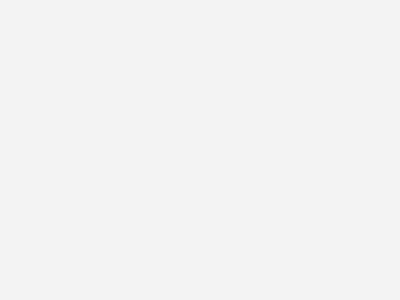
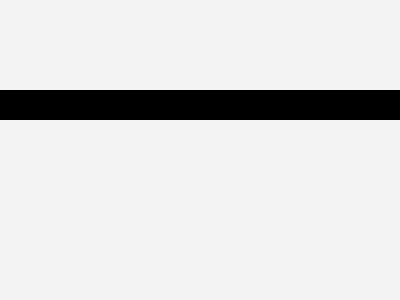
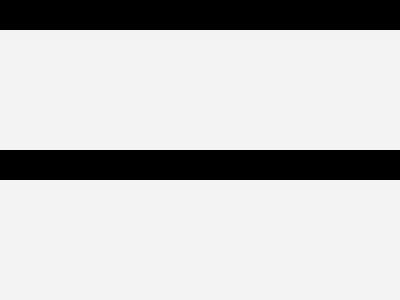
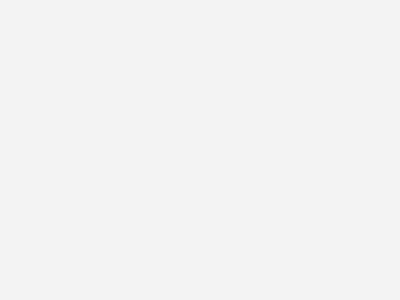
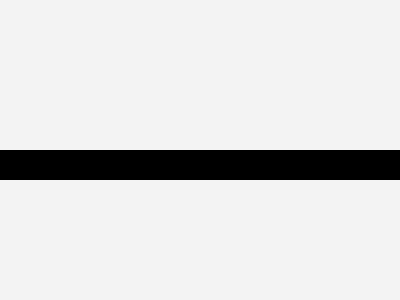
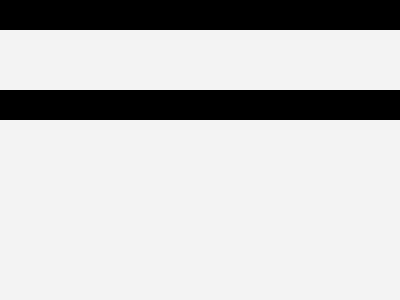
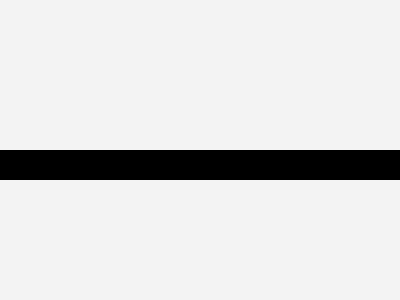
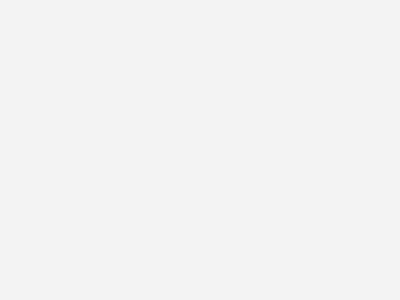
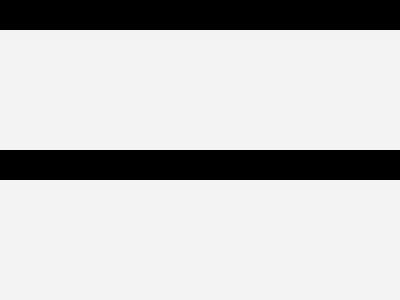
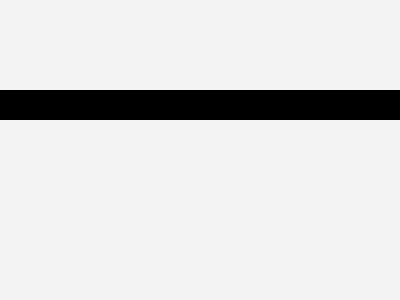
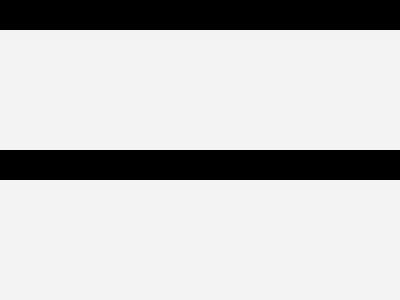
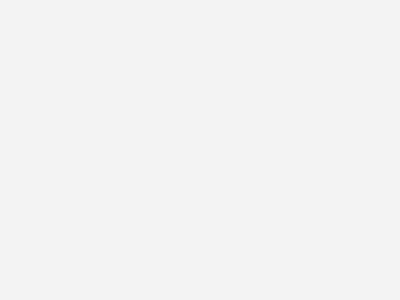
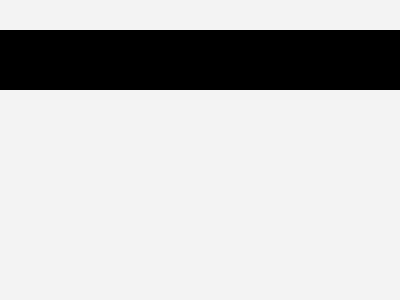
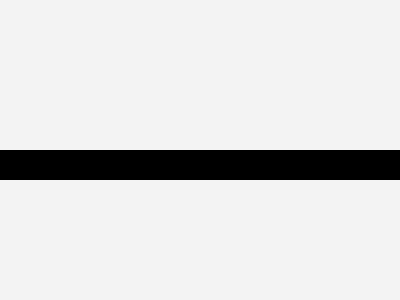
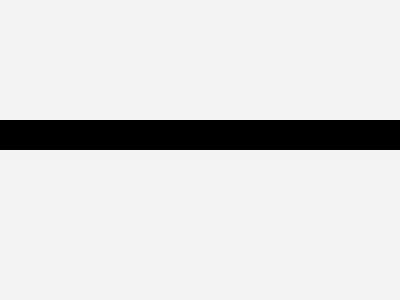
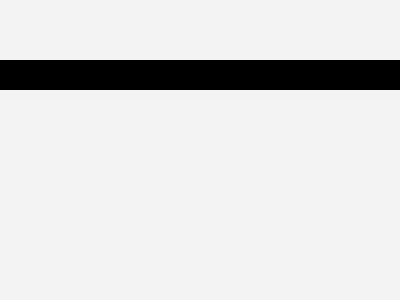
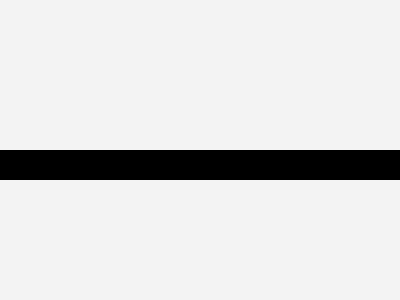
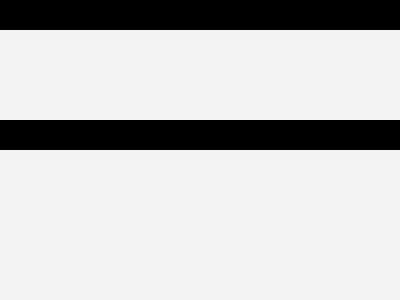
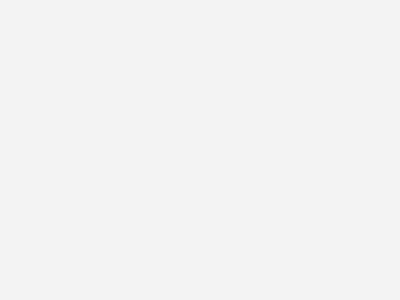
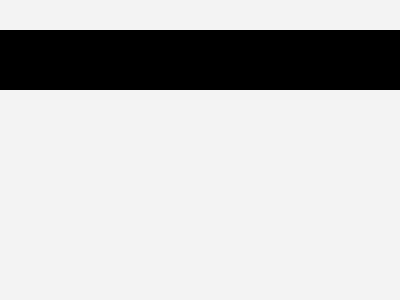
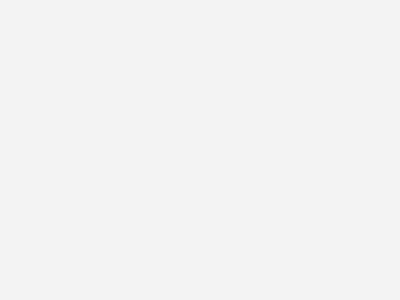
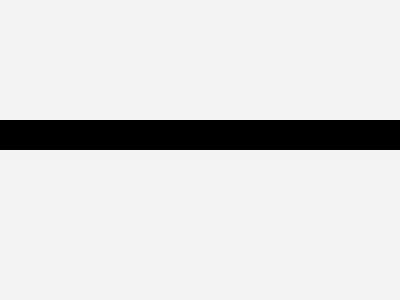
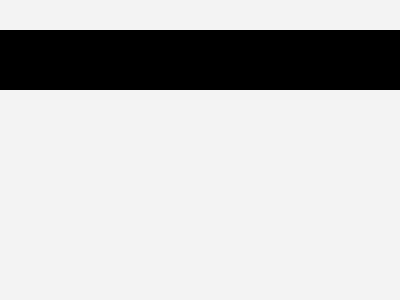
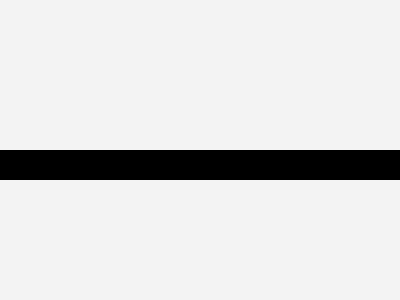
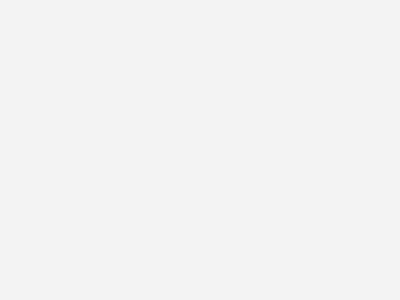
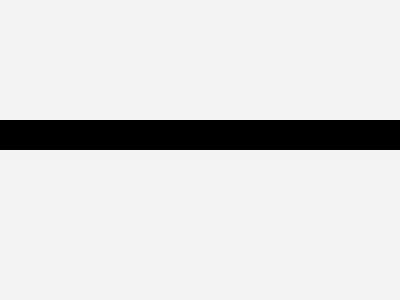
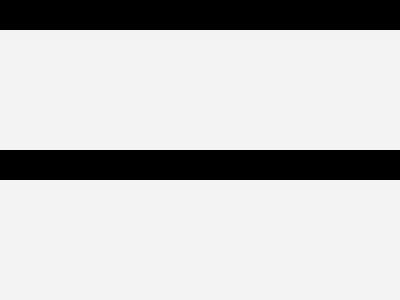
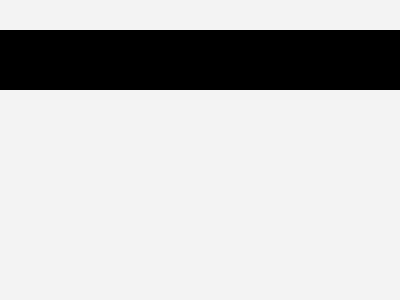
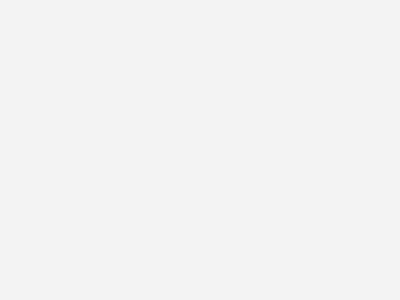
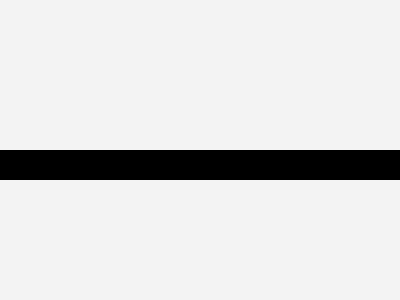
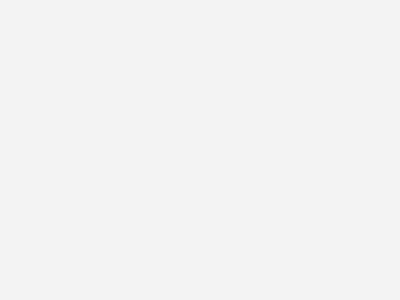
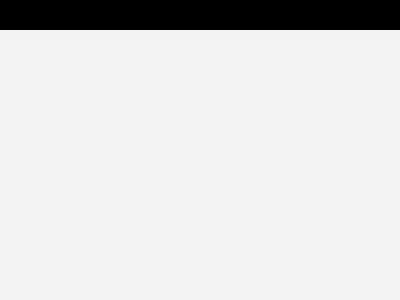
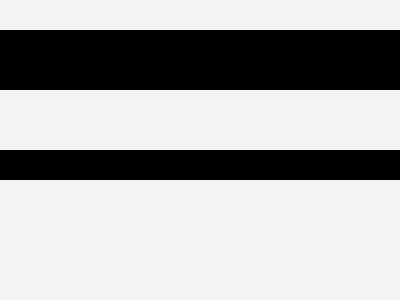
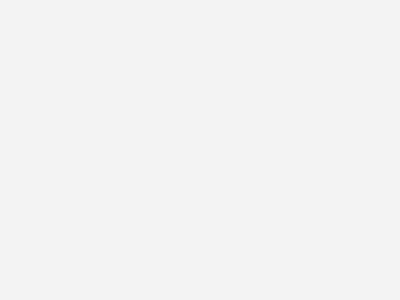
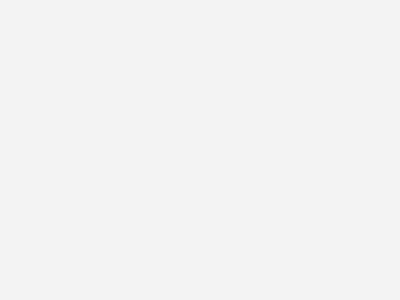
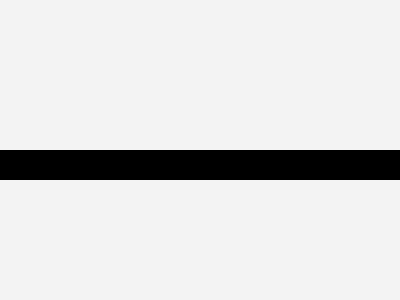
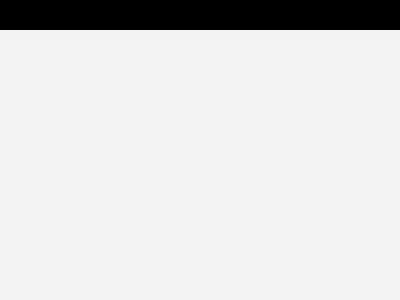
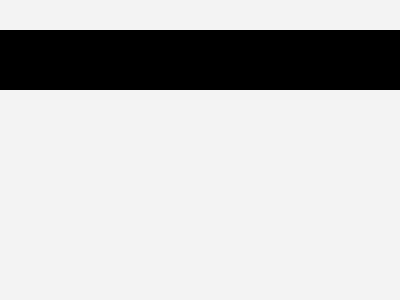
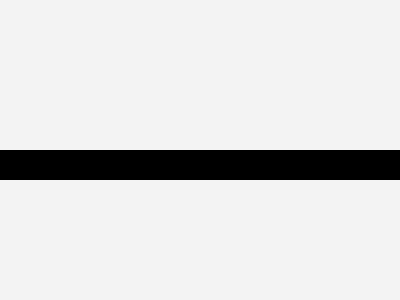
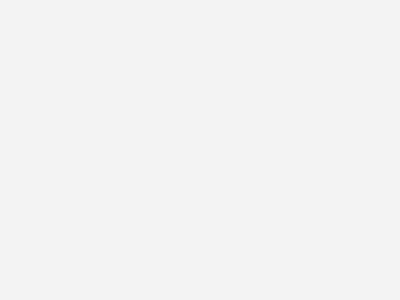
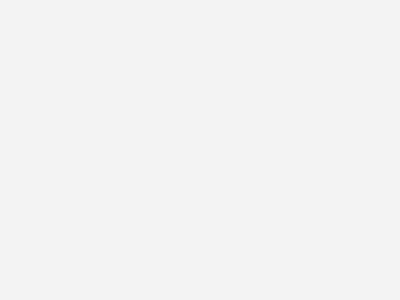
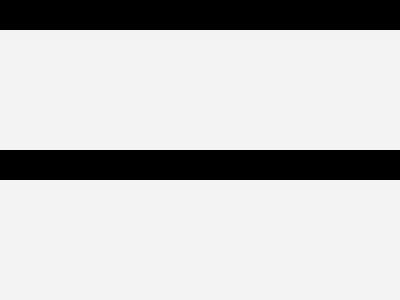
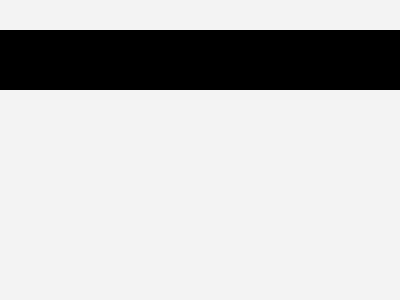
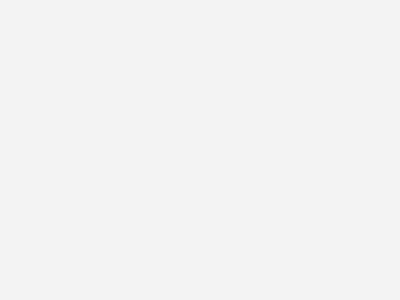
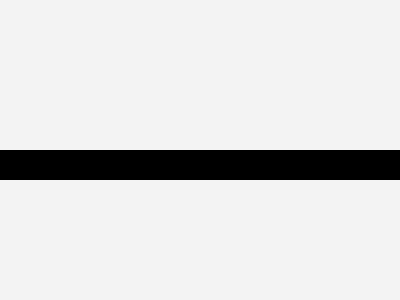
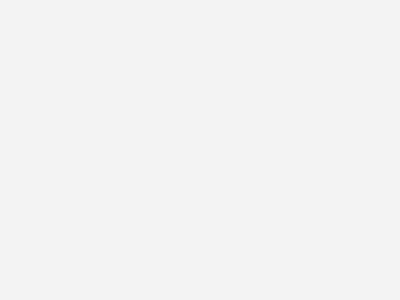
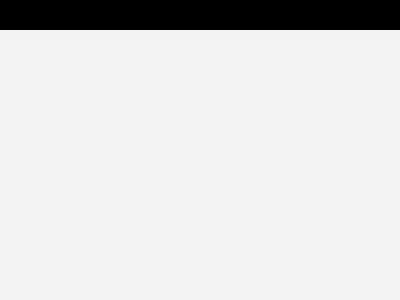
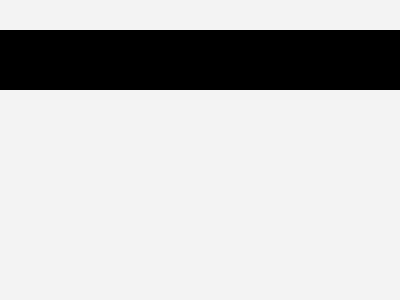
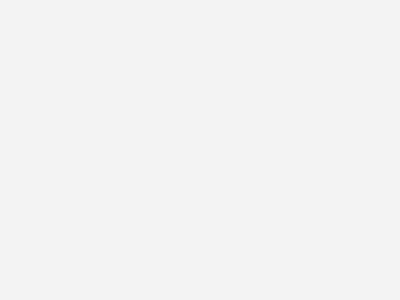
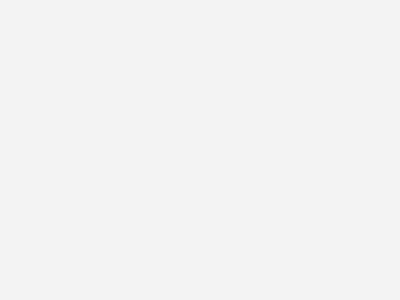
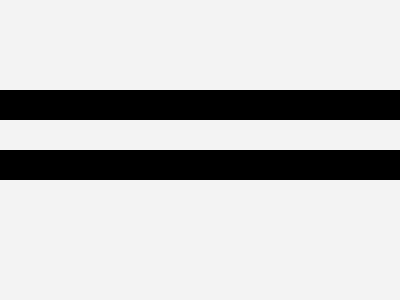
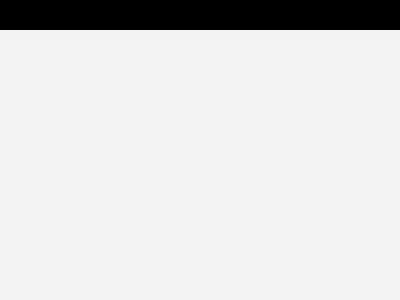
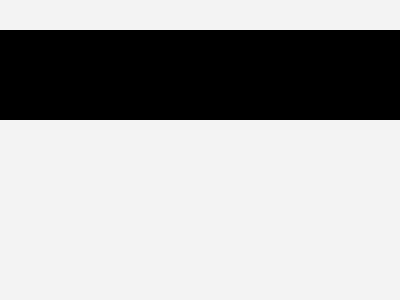
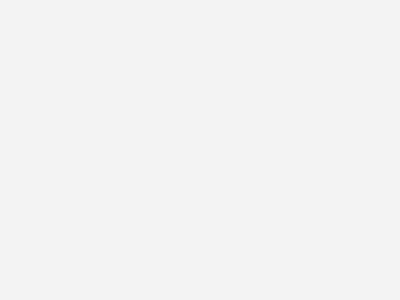
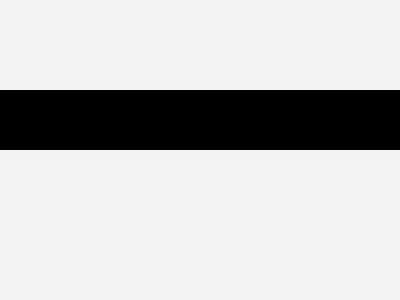
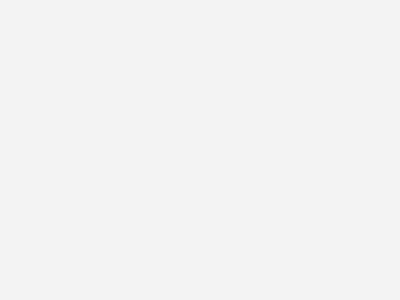
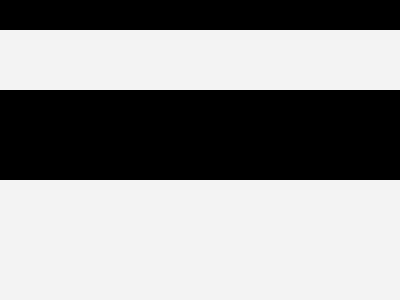
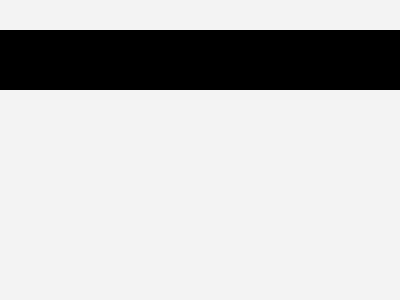
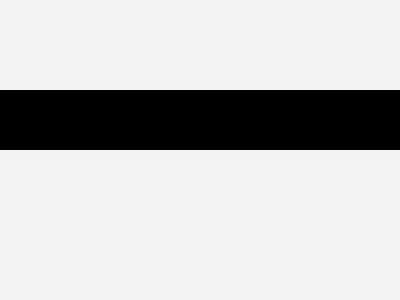
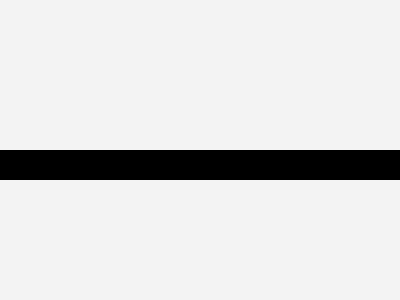
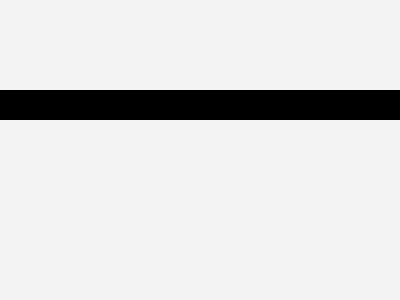
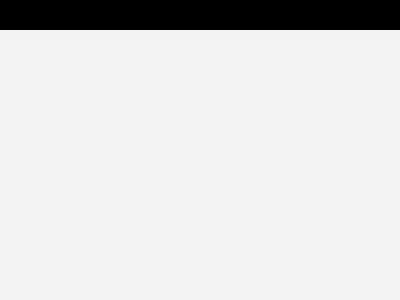
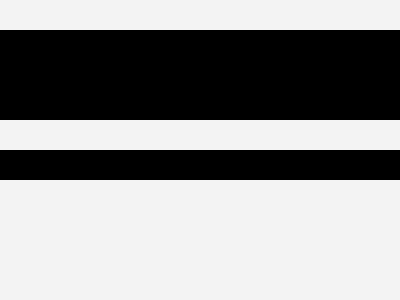
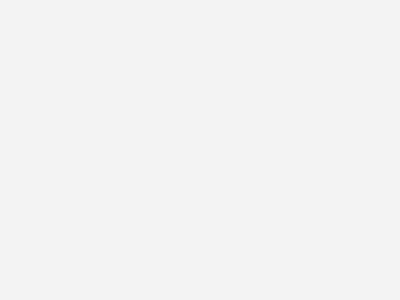
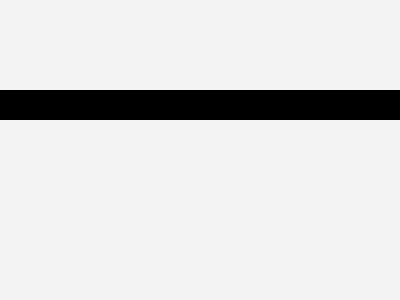
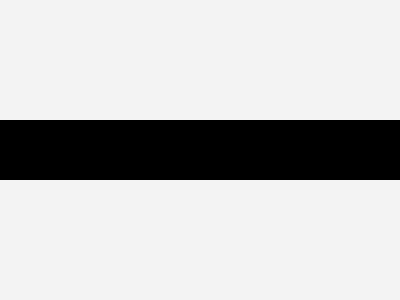
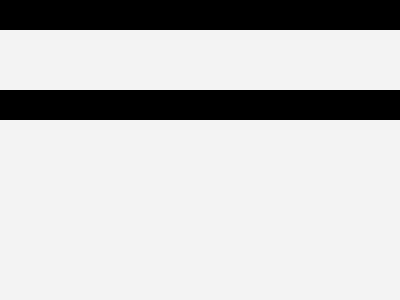
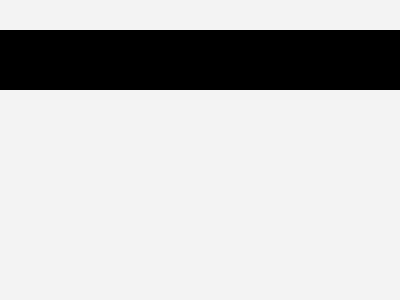
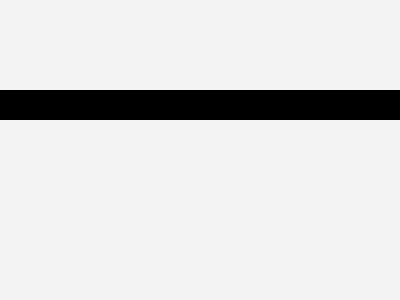
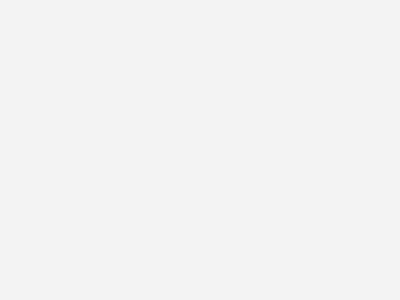
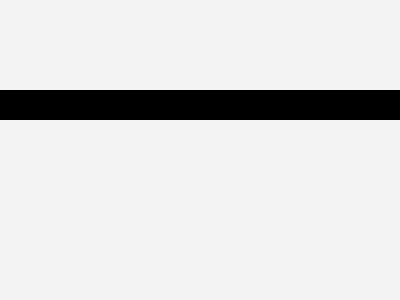
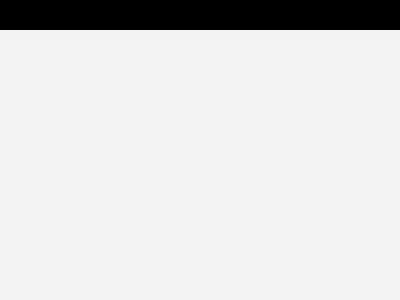
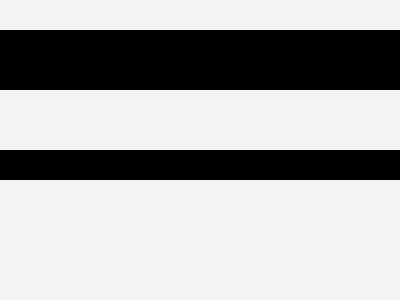
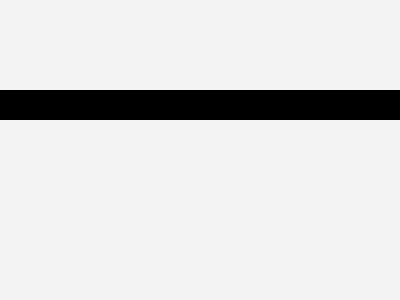
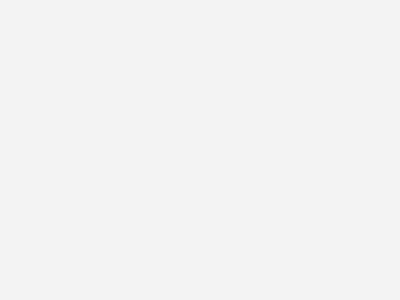
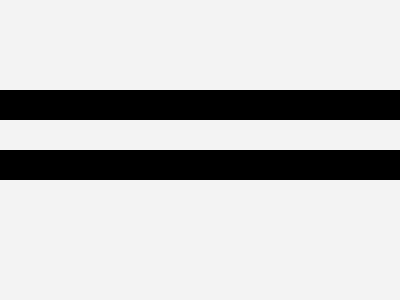
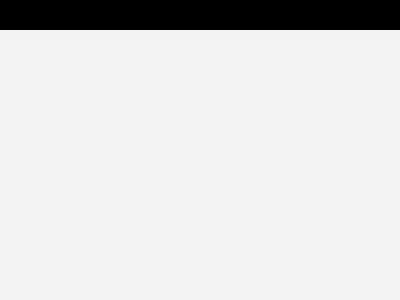
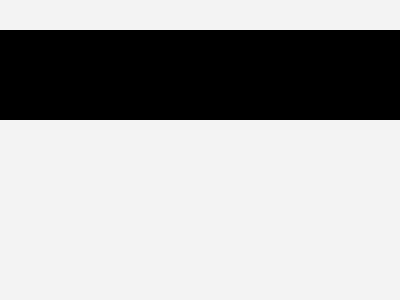
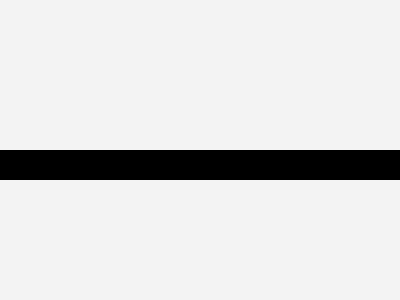
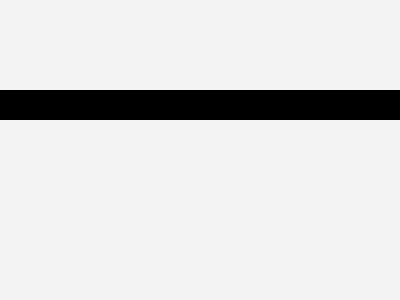
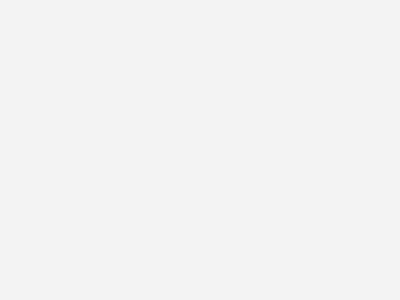
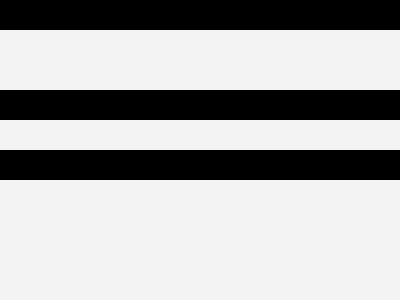
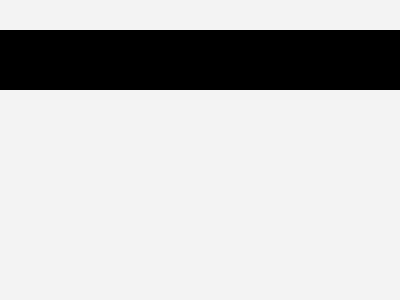
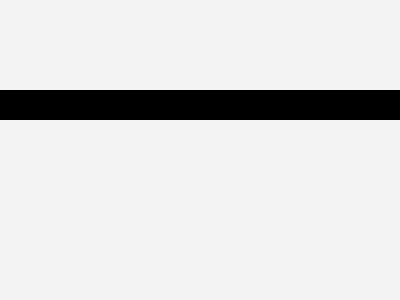
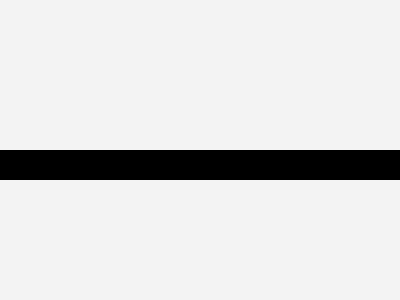
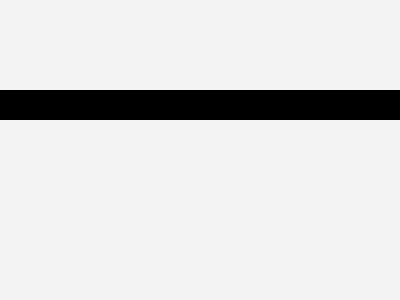
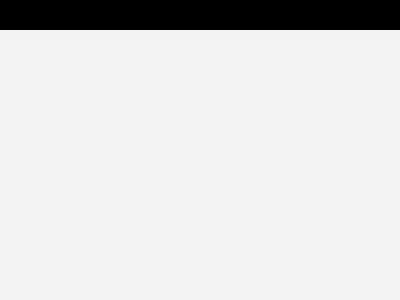
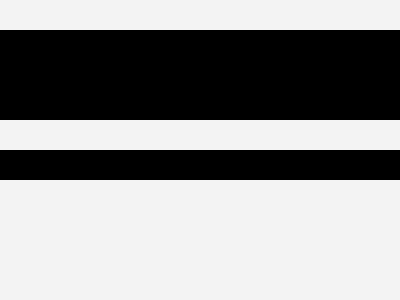
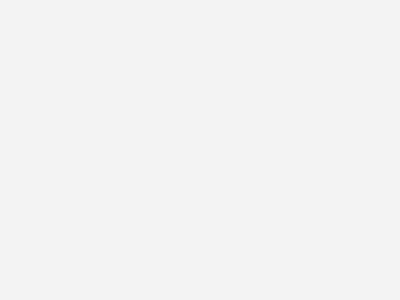
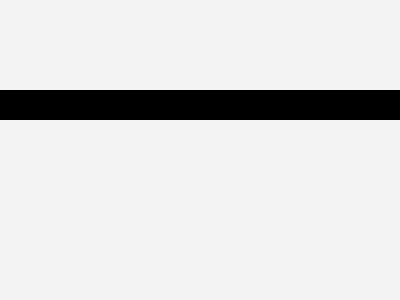
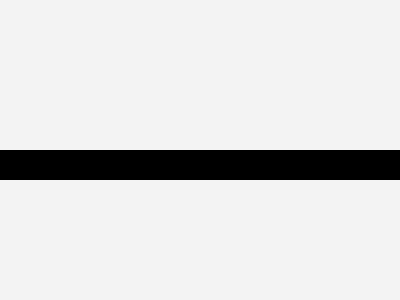
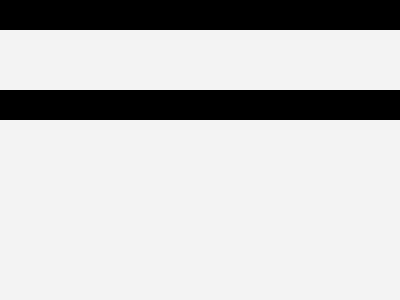
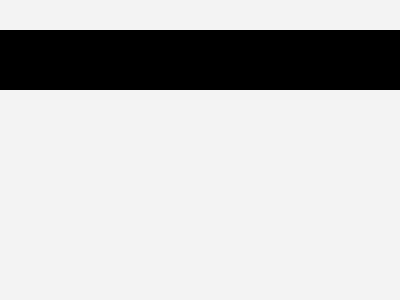
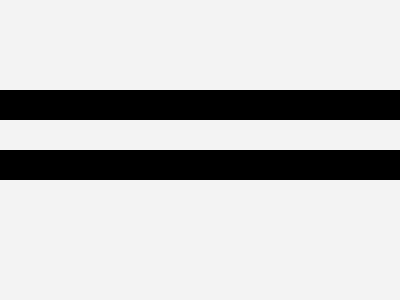
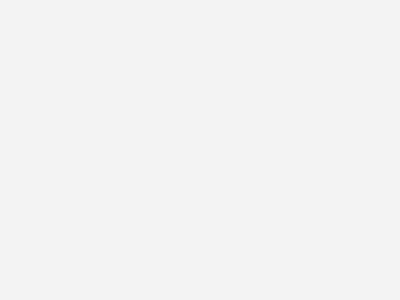
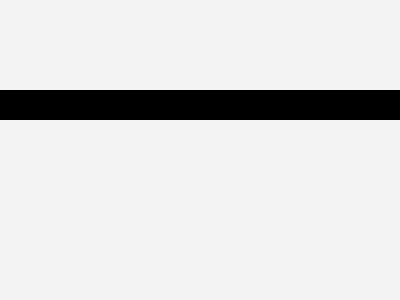
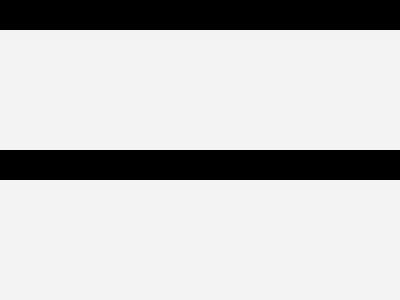
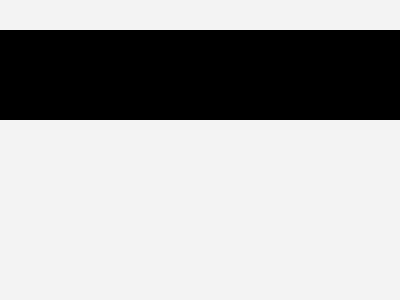
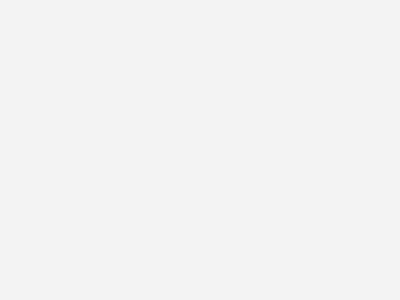
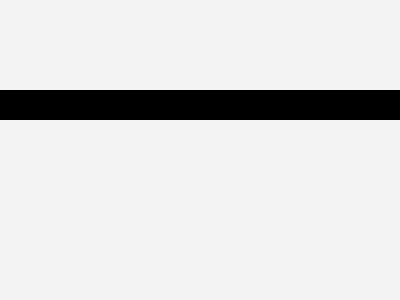
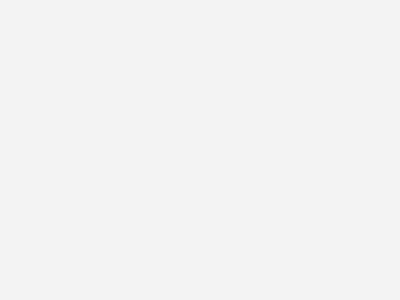
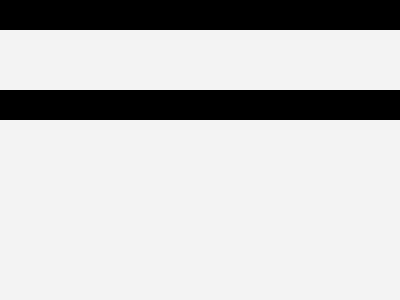
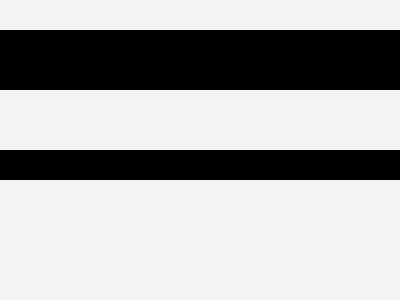
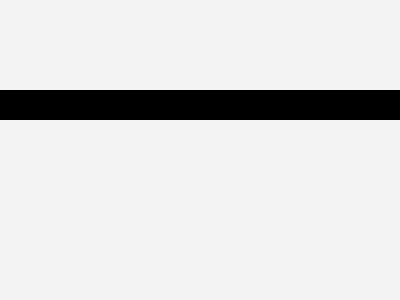
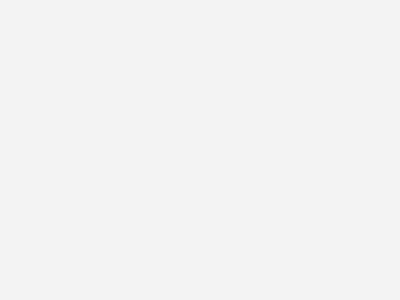
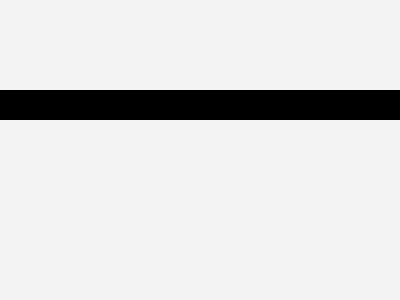
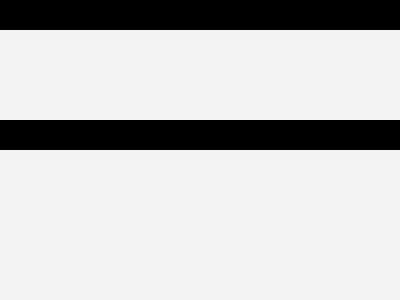
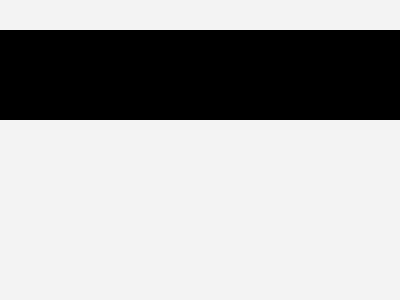
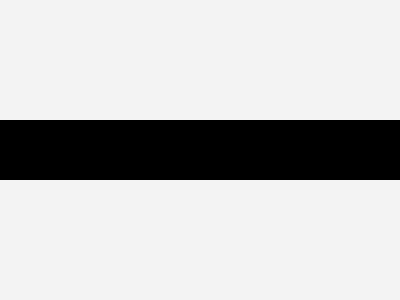
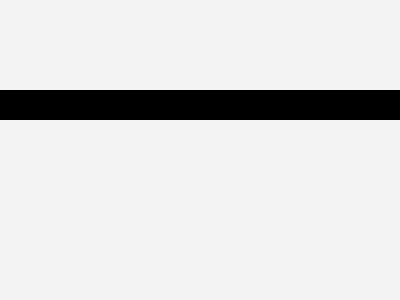
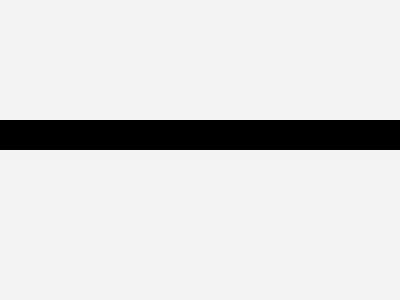
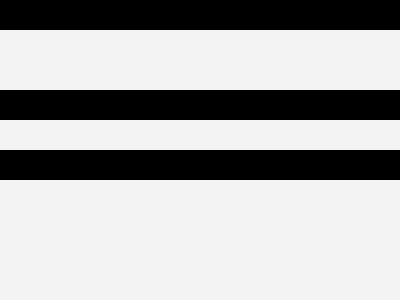
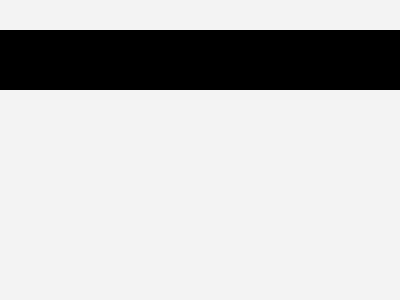
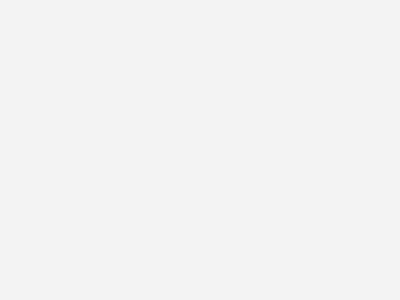
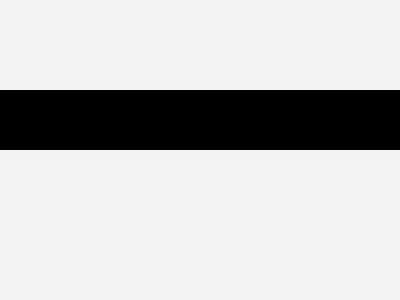
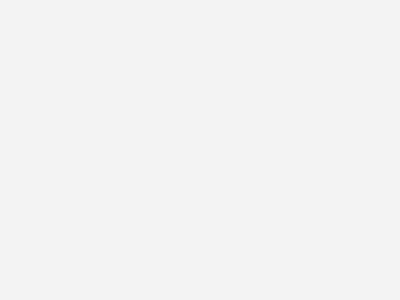
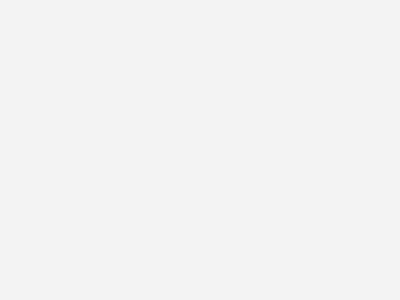
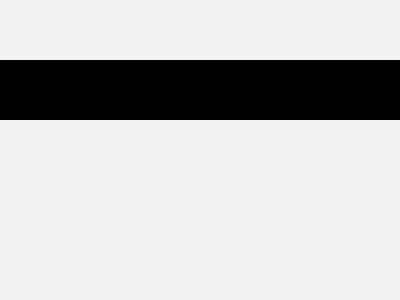
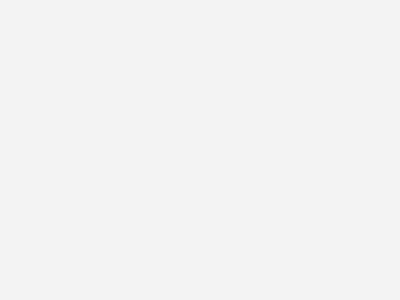
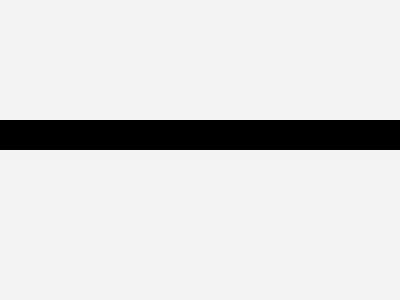
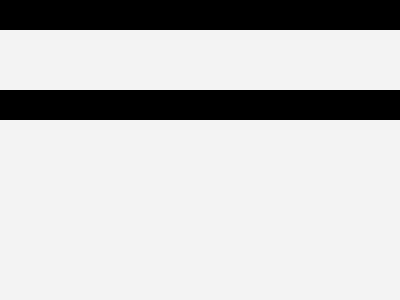
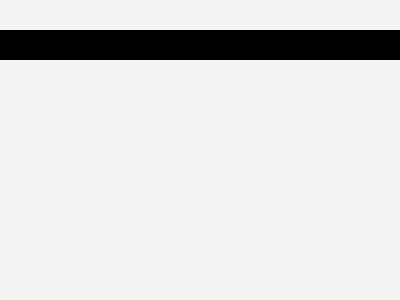
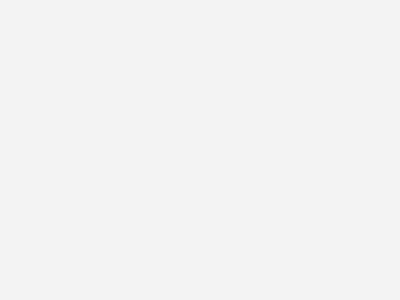
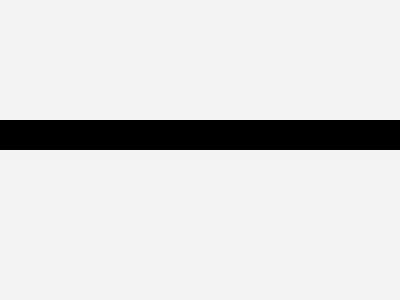
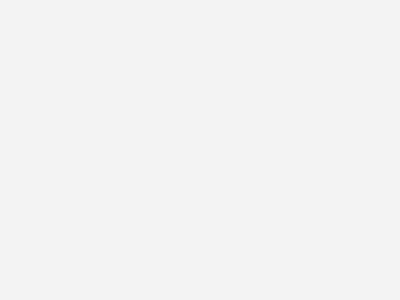
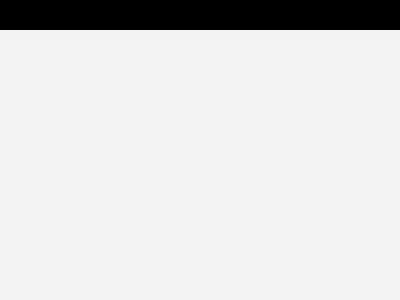
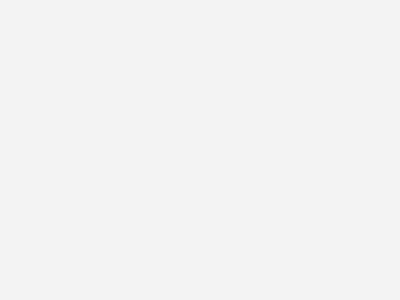
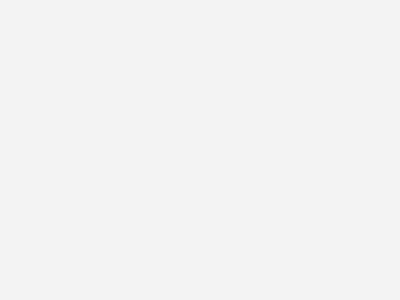
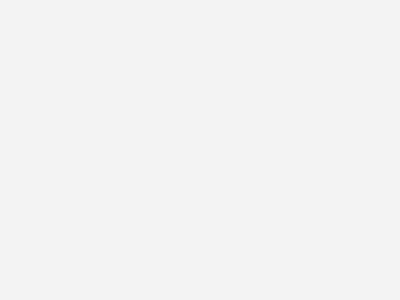
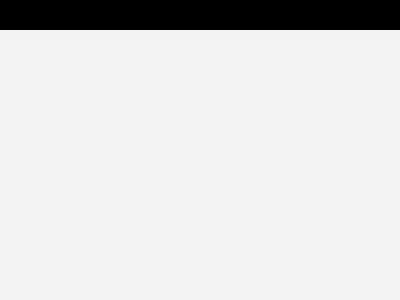
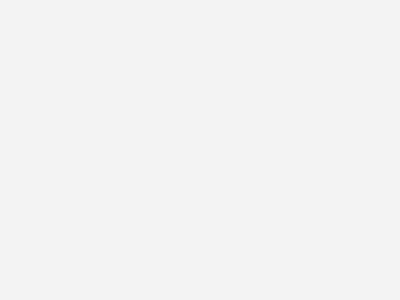
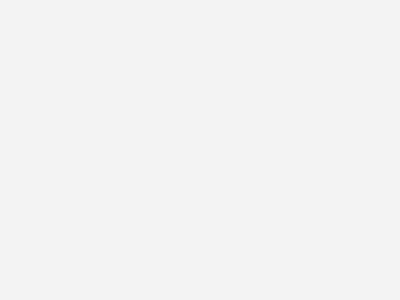
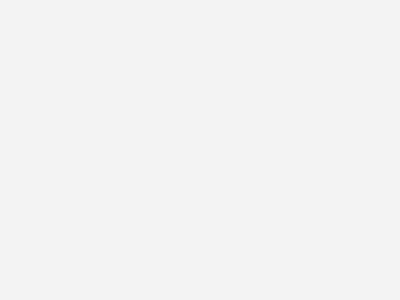
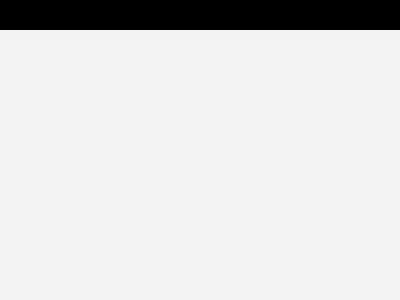
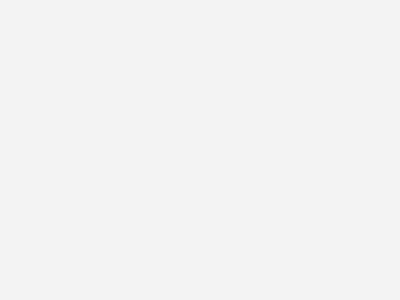
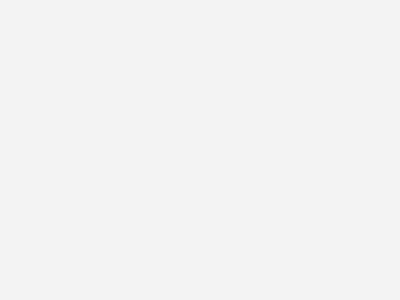
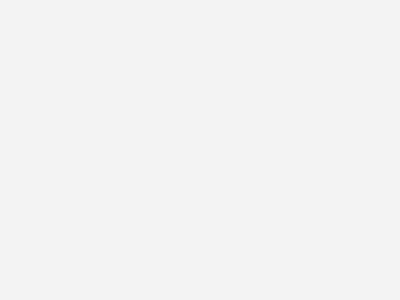
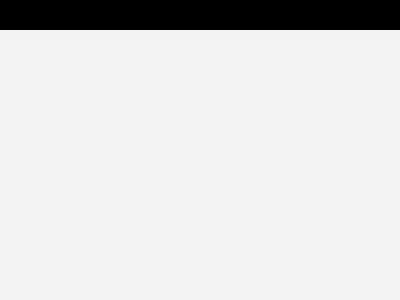
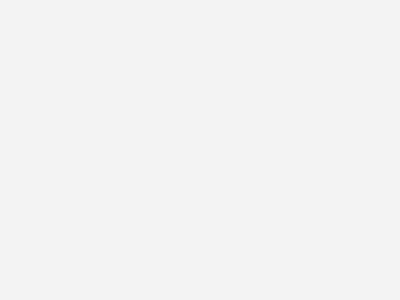
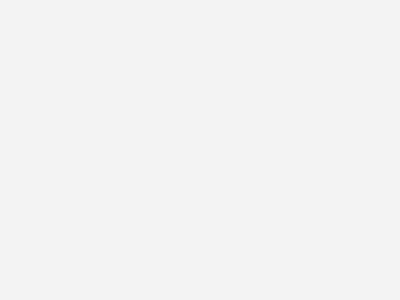

In [211]:
%matplotlib inline

I = 100

print(digits.target[I])

def life_step(X):
    fcm.step(digits.images[I].reshape(fcm.N))
    fcm1.step(np.append(fcm.th, np.zeros(36)))
    fcm2.step(np.append(fcm1.th, np.zeros(100)))
    fcm3.step(np.append(fcm2.th, np.zeros(100)))
    fcm4.step(np.sort(fcm3.th)[:50])
    fcm5.step(np.sort(fcm4.th)[:20])
    fcm6.step(np.sort(fcm5.th)[:10])
    return (fcm6.th>fcm6.TH).reshape(10,1)
    
# JSAnimation import available at https://github.com/jakevdp/JSAnimation
from JSAnimation.IPython_display import display_animation, anim_to_html
from matplotlib import animation

def life_animation(X, dpi=10, frames=10, interval=300, mode='loop'):
    """Produce a Game of Life Animation
    
    Parameters
    ----------
    X : array_like
        a two-dimensional numpy array showing the game board
    dpi : integer
        the number of dots per inch in the resulting animation.
        This controls the size of the game board on the screen
    frames : integer
        The number of frames to compute for the animation
    interval : float
        The time interval (in milliseconds) between frames
    mode : string
        The default mode of the animation.  Options are ['loop'|'once'|'reflect']
    """
    X = np.asarray(X)
    assert X.ndim == 2
    X = X.astype(bool)
    
    X_blank = np.zeros_like(X)
    figsize = (X.shape[1] * 10. / dpi, X.shape[0] * 10. / dpi)

    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1], xticks=[], yticks=[], frameon=False)
    im = ax.imshow(X, cmap=plt.cm.binary, interpolation='nearest')
    im.set_clim(-0.05, 1)  # Make background gray

    # initialization function: plot the background of each frame
    def init():
        im.set_data(X_blank)
        return (im,)

    # animation function.  This is called sequentially
    def animate(i):
        im.set_data(animate.X)
        animate.X = life_step(animate.X)
        return (im,)
    animate.X = X

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=frames, interval=interval)
    
    #print anim_to_html(anim)
    return display_animation(anim, default_mode=mode)

X = np.zeros((30, 40), dtype=bool)
life_animation(X, dpi=10, frames=140, mode='once')